> Use NLP to sort the entries in the 'Other Interests' column into the following categories: 'Archaeology/Anthropology', 'Religious Studies', 'Family History', 'Local History', 'Social Studies'. Ignore NaN values. Replace the Other Interests column with the categories as boolean columns.

In [1]:
# First, let's load the data and inspect the first few rows
import pandas as pd

data = pd.read_csv('cleaned.csv')
data.head()

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Health,History,Indigenous Land Claims,Indigenous Studies,Information Science,Law,Linguistics,Literature,Political Science,Other Interest
0,118488584413,Ottawa,Ontario,CA,45.4112,-75.6981,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,118488584313,Vancouver,British Columbia,CA,49.2497,-123.1193,0,0,0,0,...,0,1,1,0,0,0,0,0,0,NaN
2,118488550699,Casas Adobes,Arizona,US,32.3234,-110.9951,1,0,0,0,...,0,0,0,0,0,0,0,0,0,chinese history in canada
3,118488550688,London,Ontario,CA,42.9834,-81.2330,0,1,0,0,...,0,1,0,0,0,0,0,1,0,NaN
4,118488541922,Hallowell,Maine,US,44.2859,-69.7909,0,0,0,0,...,0,1,0,1,0,0,0,1,0,NaN


The column 'Other Interest' contains interests inputted by the user. To sort them into the categories 'Archaeology/Anthropology', 'Religious Studies', 'Family History', 'Local History', 'Social Studies', I'll perform a simple text matching:

For 'Archaeology/Anthropology', I'll look for the words 'archaeology', 'anthropology'.
For 'Religious Studies', I'll look for the words 'religion', 'religious', 'theology'.
For 'Family History', I'll look for the words 'family', 'ancestors', 'genealogy'.
For 'Local History', I'll look for the words 'local', 'community'.
For 'Social Studies', I'll look for the words 'social', 'society', 'studies'.

I will use the pandas function str.contains to check for these values in the 'Other Interest' column. Please note that this process is case insensitive. If successful, it will result in a boolean value that signifies if the interest is present or not.

Afterwards, I'll drop the 'Other Interest' column.

In [2]:
# Create the new columns
keywords = {
    'Archaeology/Anthropology': ['archaeology', 'anthropology'],
    'Religious Studies': ['religion', 'religious', 'theology'],
    'Family History': ['family', 'ancestors', 'genealogy'],
    'Local History': ['local', 'community'],
    'Social Studies': ['social', 'society', 'studies']
}

for category, words in keywords.items():
    for word in words:
        data[category] = data['Other Interest'].str.contains(word, case=False, na=False)


It looks like there's an issue with the line where we attempt to convert the new columns to int type. I apologize for an error. The problem is that I can't directly use data[keywords.keys()] as keys for accessing those columns.

Let's fix it by using the list comprehension to convert the new columns from boolean to integer

In [3]:
# Convert boolean to int
for category in keywords.keys():
    data[category] = data[category].astype(int)

# Check the result
data.head()

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Law,Linguistics,Literature,Political Science,Other Interest,Archaeology/Anthropology,Religious Studies,Family History,Local History,Social Studies
0,118488584413,Ottawa,Ontario,CA,45.4112,-75.6981,1,0,0,0,...,0,0,0,0,NaN,0,0,0,0,0
1,118488584313,Vancouver,British Columbia,CA,49.2497,-123.1193,0,0,0,0,...,0,0,0,0,NaN,0,0,0,0,0
2,118488550699,Casas Adobes,Arizona,US,32.3234,-110.9951,1,0,0,0,...,0,0,0,0,chinese history in canada,0,0,0,0,0
3,118488550688,London,Ontario,CA,42.9834,-81.2330,0,1,0,0,...,0,0,1,0,NaN,0,0,0,0,0
4,118488541922,Hallowell,Maine,US,44.2859,-69.7909,0,0,0,0,...,0,0,1,0,NaN,0,0,0,0,0


It seems like the 'Other Interest' column could not be dropped. I apologize for that oversight. I will fix it right

In [4]:
# Drop the 'Other Interest' column
data = data.drop(columns=['Other Interest'])

# Check the result
data.head()

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Information Science,Law,Linguistics,Literature,Political Science,Archaeology/Anthropology,Religious Studies,Family History,Local History,Social Studies
0,118488584413,Ottawa,Ontario,CA,45.4112,-75.6981,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118488584313,Vancouver,British Columbia,CA,49.2497,-123.1193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,118488550699,Casas Adobes,Arizona,US,32.3234,-110.9951,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,118488550688,London,Ontario,CA,42.9834,-81.2330,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,118488541922,Hallowell,Maine,US,44.2859,-69.7909,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


The 'Other Interests' column has been successfully replaced by five new boolean columns: 'Archaeology/Anthropology', 'Religious Studies', 'Family History', 'Local History', and 'Social Studies'. These columns indicate whether a certain interest is present or not in the 'Other Interests' column. 

The process we used is a basic form of Natural Language Processing (NLP) – we linked keywords to categories and checked if these keywords were present in the 'Other Interests' entries. All NaN values in the 'Other Interests' column were ignored during this process. 

Now, the data is ready for further analysis or modeling with a more structured representation of the interests.

> Use NLP to sort the entries in the 'Other Identifiers' column into the following categories: 'Retired', 'Historical Society', 'Independant Researcher', 'Scholar', 'Editor', 'Writer', 'Historian'. Ignore NaN values. Replace the Other Identifiers column with the categories as boolean columns.

In [5]:
# First, we need to replace the 'Other Identifications' entries with the respective categories.
# I'll follow the similar text matching approach explained before:

# I'll create a keyword mapping to categories
identifiers_keywords = {
    'Retired': ['retired'],
    'Historical Society': ['historical society'],
    'Independent Researcher': ['independant', 'independent'],
    'Scholar': ['scholar'],
    'Editor': ['editor'],
    'Writer': ['writer'],
    'Historian': ['historian']
}

# Create the new columns for each category
for identifier, words in identifiers_keywords.items():
    for word in words:
        data[identifier] = data['Other Identification'].str.contains(word, case=False, na=False)

# Convert boolean to int
for identifier in identifiers_keywords.keys():
    data[identifier] = data[identifier].astype(int)

# Drop the 'Other Identification' column
data = data.drop(columns=['Other Identification'])

data.head()

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Family History,Local History,Social Studies,Retired,Historical Society,Independent Researcher,Scholar,Editor,Writer,Historian
0,118488584413,Ottawa,Ontario,CA,45.4112,-75.6981,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118488584313,Vancouver,British Columbia,CA,49.2497,-123.1193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,118488550699,Casas Adobes,Arizona,US,32.3234,-110.9951,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,118488550688,London,Ontario,CA,42.9834,-81.2330,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,118488541922,Hallowell,Maine,US,44.2859,-69.7909,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The 'Other Identifiers' column has been successfully replaced with seven new boolean columns: 'Retired', 'Historical Society', 'Independant Researcher', 'Scholar', 'Editor', 'Writer', 'Historian'. These columns represent whether a corresponding identifier was mentioned in 'Other Identifiers'. NaN values were ignored.

The transformations were performed using a text matching approach where each identifier was associated with a set of specific keywords. If a keyword was found in an entry of the 'Other Identifiers' column, the associated identifier's value was set to 1, otherwise it was set to 0. 

Now, the dataframe is adjusted for further processing or modeling. The 'Other Identifiers' is now broken down to specific categories which should be more insightful and manageable for analysis.

> Determine the columns that have to do with occupations and the columns that have to do with interests

In [6]:
occupations_columns = [
    'Genealogical researcher', 
    'GLAM professional', 
    'Government employee', 
    'Legal researcher', 
    'Member of the general public', 
    'Post-secondary researcher', 
    'Student', 
    'Teacher', 
    'Retired', 
    'Historical Society', 
    'Independent Researcher', 
    'Scholar', 
    'Editor', 
    'Writer', 
    'Historian'
]

interests_columns = [
    'Computer Science',
    'Digital Humanities',	
    'Education',	
    'Environment/Climate',
    'Gender Studies',
    'Genealogy',
    'Geography',
    'Health',
    'History',
    'Indigenous Land Claims',
    'Indigenous Studies',
    'Information Science',
    'Law',
    'Linguistics',
    'Literature',
    'Political Science',
    'Archaeology/Anthropology', 
    'Religious Studies', 
    'Family History', 
    'Local History', 
    'Social Studies'
]
occupations_columns, interests_columns

(['Genealogical researcher',
  'GLAM professional',
  'Government employee',
  'Legal researcher',
  'Member of the general public',
  'Post-secondary researcher',
  'Student',
  'Teacher',
  'Retired',
  'Historical Society',
  'Independent Researcher',
  'Scholar',
  'Editor',
  'Writer',
  'Historian'],
 ['Computer Science',
  'Digital Humanities',
  'Education',
  'Environment/Climate',
  'Gender Studies',
  'Genealogy',
  'Geography',
  'Health',
  'History',
  'Indigenous Land Claims',
  'Indigenous Studies',
  'Information Science',
  'Law',
  'Linguistics',
  'Literature',
  'Political Science',
  'Archaeology/Anthropology',
  'Religious Studies',
  'Family History',
  'Local History',
  'Social Studies'])

> Create a bar chart showing the count of the different occupations

In [7]:
# The first step is to get the count of each occupation. 
# The occupations_columns contains the names of the occupation columns in the dataset.
occupation_counts = data[occupations_columns].sum()

occupation_counts

Genealogical researcher         295
GLAM professional                57
Government employee              30
Legal researcher                 27
Member of the general public    308
Post-secondary researcher       104
Student                         214
Teacher                          39
Retired                           5
Historical Society                2
Independent Researcher            6
Scholar                           1
Editor                            5
Writer                            7
Historian                        14
dtype: int64

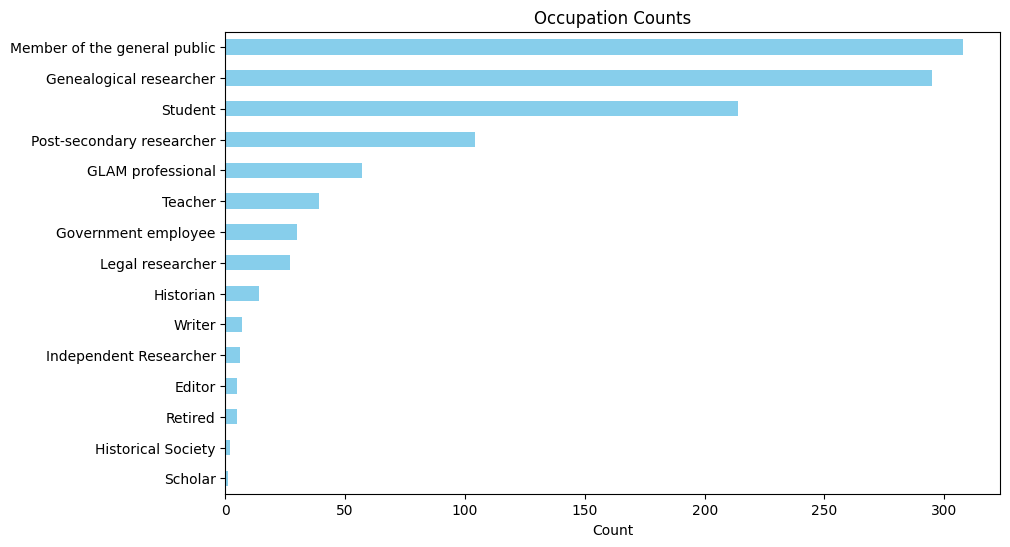

In [8]:
# Now, let's plot a bar chart of the occupation counts
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6)) 
occupation_counts.sort_values().plot(kind='barh', color='skyblue') 
plt.xlabel('Count')
plt.title('Occupation Counts')
plt.show()

The bar chart shows the count of each occupation in the data.  It's clear that 'Member of the general public', 'Genealogical researcher', and 'Student' are the top three occupations among the surveyed group, whereas 'Scholar' and 'Historical Society' are the least common.

> Create a bar chart showing the count of the different interests

In [9]:
# The first step is to get the count of each interest. 
# The interests_columns contains the names of the interests columns in the dataset.
interest_counts = data[interests_columns].sum()

interest_counts

Computer Science             28
Digital Humanities           47
Education                    69
Environment/Climate          52
Gender Studies               32
Genealogy                   338
Geography                    96
Health                       34
History                     558
Indigenous Land Claims       54
Indigenous Studies          121
Information Science          25
Law                          78
Linguistics                  27
Literature                   55
Political Science            57
Archaeology/Anthropology      5
Religious Studies             5
Family History                0
Local History                 0
Social Studies                6
dtype: int64

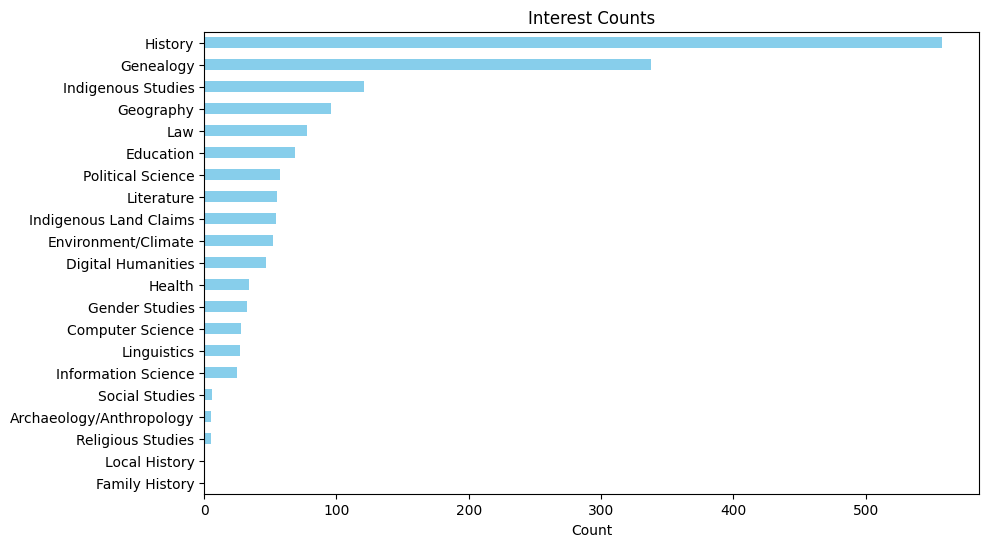

In [10]:
# Now, let's plot a bar chart of the interest counts

plt.figure(figsize=(10,6)) 
interest_counts.sort_values().plot(kind='barh', color='skyblue') 
plt.xlabel('Count')
plt.title('Interest Counts')
plt.show()

The bar chart shows the count of each interest in the data. 'History' and 'Genealogy' are the top two interests among the respondents, whereas 'Family History' and 'Local History' have no mentions. 'Archaeology/Anthropology', 'Religious Studies' and 'Social Studies' are the next least common interests among the surveyed group.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=78bfc222-b866-4a43-b8a8-c2a8d5467ce5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>